# import necessary package

In [133]:
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.optimizers import SGD
import math
import matplotlib.pyplot as plt

# load monthly number of birth data

In [86]:
birth = pd.read_csv('./data/UNdata_Export_20230216_185343649.csv',encoding='ISO-8859-1')
# remove rows with Month = 'Unknown'
birth = birth[birth['Month'] != 'Unknown']
# remove rows with Month = 'Total'
birth = birth[birth['Month'] != 'Total']
# remove rows Month contain '-'
birth = birth[~birth['Month'].str.contains('-')]
# remove rows Year = 2022
birth = birth[birth['Year'] != 2022]

# create a new column 'Date' by combining 'Year' and 'Month' columns
birth['Date'] = pd.to_datetime(birth['Year'].astype(str) + '-' + birth['Month'] + '-01', format='%Y-%B-%d')

birth.head()

,Country or Area,Year,Month,Record Type,Value,Date
6,?land Islands,2020,January,Data tabulated by year of occurrence,11.0,2020-01-01
7,?land Islands,2020,February,Data tabulated by year of occurrence,24.0,2020-02-01
8,?land Islands,2020,March,Data tabulated by year of occurrence,31.0,2020-03-01
9,?land Islands,2020,April,Data tabulated by year of occurrence,22.0,2020-04-01
10,?land Islands,2020,May,Data tabulated by year of occurrence,20.0,2020-05-01


In [88]:
birth_avg = birth.groupby('Date')['Value'].mean().reset_index()

In [89]:
# convert the df into ts format
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

ts_data = birth_avg.set_index('Date')
ts_data = ts_data.resample('M').mean()
ts_data.head()

,Value
Date,
1967-01-31,6300.4
1967-02-28,5340.6
1967-03-31,5770.6
1967-04-30,5391.6
1967-05-31,5718.2


In [90]:
float_data = ts_data['Value'].astype(float)
float_data.head()

Date
1967-01-31    6300.4
1967-02-28    5340.6
1967-03-31    5770.6
1967-04-30    5391.6
1967-05-31    5718.2
Freq: M, Name: Value, dtype: float64

# plot the ts data

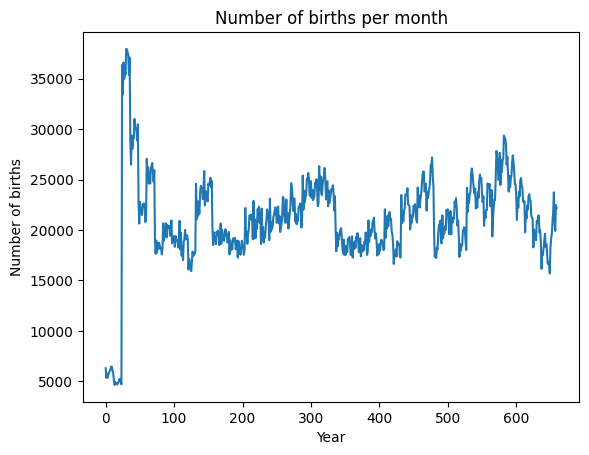

In [181]:
from matplotlib import pyplot as plt
plt.plot(float_data)
plt.title('Number of births per month')
plt.xlabel('Year')
plt.ylabel('Number of births')
plt.show()

In [92]:
# change float_data into shape (len(float_data), 1)
float_data = float_data.values.reshape(len(float_data), 1)
float_data.shape

(660, 1)

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(float_data).flatten()
n = len(data)
# Point for splitting data into train and test
split = int(n*0.8)
train_data = data[range(split)]
test_data = data[split:]

In [94]:
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [107]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [96]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# create and train a RNN model without regularization

In [108]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2,validation_split=0.2)

Epoch 1/20
34/34 - 2s - loss: 0.1489 - val_loss: 0.0835 - 2s/epoch - 46ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0847 - val_loss: 0.0388 - 124ms/epoch - 4ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0512 - val_loss: 0.0185 - 114ms/epoch - 3ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0359 - val_loss: 0.0099 - 109ms/epoch - 3ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0282 - val_loss: 0.0064 - 128ms/epoch - 4ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0246 - val_loss: 0.0049 - 112ms/epoch - 3ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0228 - val_loss: 0.0043 - 124ms/epoch - 4ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0217 - val_loss: 0.0043 - 105ms/epoch - 3ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0213 - val_loss: 0.0044 - 179ms/epoch - 5ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0210 - val_loss: 0.0044 - 226ms/epoch - 7ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0208 - val_loss: 0.0046 - 141ms/epoch - 4ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0205 - val_loss: 0.0046 - 111ms/epoch - 3ms/step
Epoch 13/20
34/34 - 0s - lo

# plot the train and validation loss curve

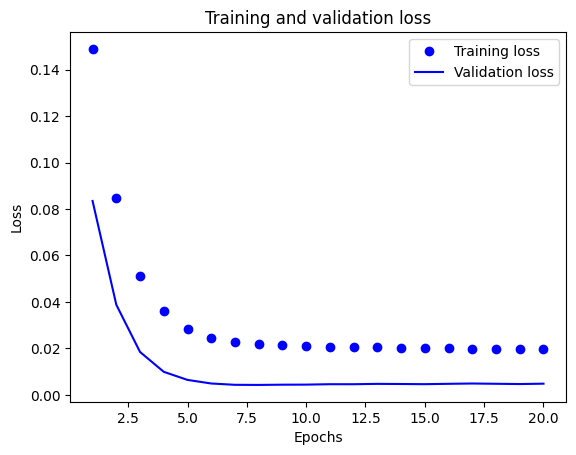

In [109]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [110]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 33ms/step
Train RMSE: 0.127 RMSE
Test RMSE: 0.068 RMSE


# plot the result

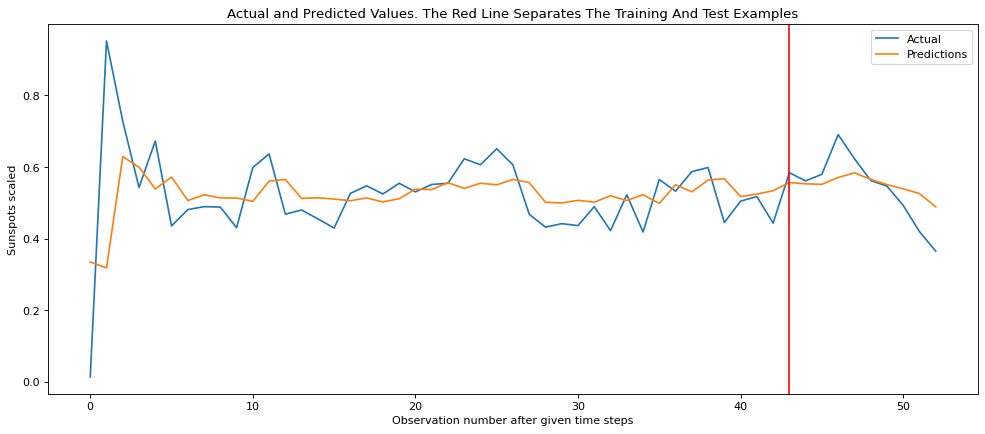

In [111]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)


# create and train a RNN model with regularization

In [112]:
def create_RNN(hidden_units, dense_units, input_shape, activation, dropout_rate):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [113]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'], dropout_rate=0.2)
history = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2,validation_split=0.2)

Epoch 1/20
34/34 - 1s - loss: 0.3900 - val_loss: 0.2584 - 1s/epoch - 34ms/step
Epoch 2/20
34/34 - 0s - loss: 0.2255 - val_loss: 0.0962 - 268ms/epoch - 8ms/step
Epoch 3/20
34/34 - 0s - loss: 0.1308 - val_loss: 0.0319 - 113ms/epoch - 3ms/step
Epoch 4/20
34/34 - 0s - loss: 0.1019 - val_loss: 0.0144 - 123ms/epoch - 4ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0734 - val_loss: 0.0096 - 116ms/epoch - 3ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0742 - val_loss: 0.0074 - 107ms/epoch - 3ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0622 - val_loss: 0.0067 - 121ms/epoch - 4ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0824 - val_loss: 0.0061 - 103ms/epoch - 3ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0637 - val_loss: 0.0066 - 120ms/epoch - 4ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0633 - val_loss: 0.0061 - 277ms/epoch - 8ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0690 - val_loss: 0.0059 - 115ms/epoch - 3ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0845 - val_loss: 0.0057 - 107ms/epoch - 3ms/step
Epoch 13/20
34/34 - 0s - lo

# plot the train and validation loss curve

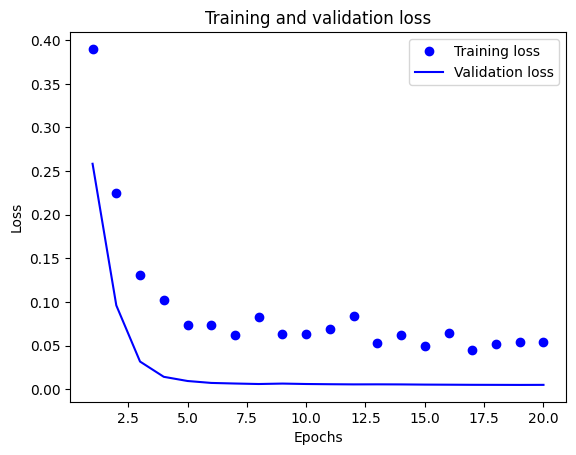

In [114]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [115]:
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 132ms/step
Train RMSE: 0.175 RMSE
Test RMSE: 0.144 RMSE


# plot the result

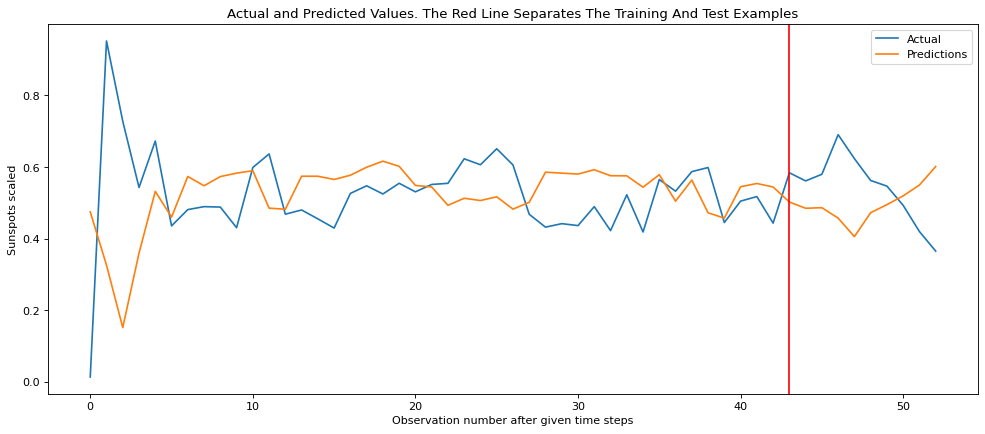

In [116]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)


# create and train a LSTM model without regularization

In [122]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(12, 1)))
lstm.add(LSTM(units=50))
lstm.add(Dense(units=1))

# compile the lstm
lstm.compile(optimizer='adam', loss='mean_squared_error')

# train the lstm
lstm_history = lstm.fit(trainX, trainY, epochs=20, batch_size=1,verbose=2, validation_split=0.2)


Epoch 1/20
34/34 - 4s - loss: 0.0626 - val_loss: 0.0082 - 4s/epoch - 111ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0231 - val_loss: 0.0127 - 272ms/epoch - 8ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0218 - val_loss: 0.0062 - 283ms/epoch - 8ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0206 - val_loss: 0.0062 - 243ms/epoch - 7ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0217 - val_loss: 0.0102 - 356ms/epoch - 10ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0208 - val_loss: 0.0102 - 237ms/epoch - 7ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0199 - val_loss: 0.0048 - 277ms/epoch - 8ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0225 - val_loss: 0.0076 - 243ms/epoch - 7ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0202 - val_loss: 0.0061 - 247ms/epoch - 7ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0201 - val_loss: 0.0068 - 243ms/epoch - 7ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0202 - val_loss: 0.0044 - 242ms/epoch - 7ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0205 - val_loss: 0.0190 - 238ms/epoch - 7ms/step
Epoch 13/20
34/34 - 0s - 

# plot the train and validation data loss curve

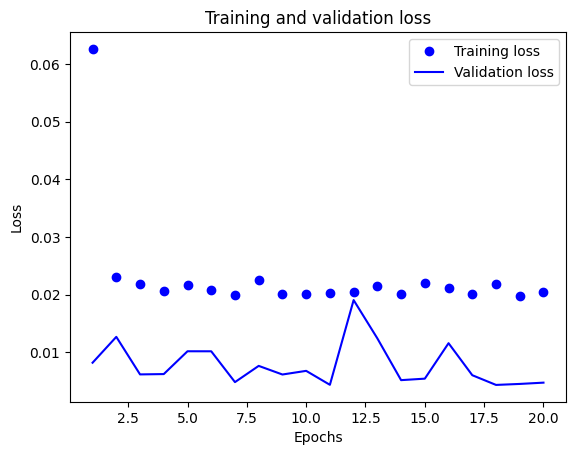

In [124]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get RMSE value for train and test data

In [126]:
# make predictions
train_predict = lstm.predict(trainX)
test_predict = lstm.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 24ms/step
Train RMSE: 0.129 RMSE
Test RMSE: 0.086 RMSE


# plot the result

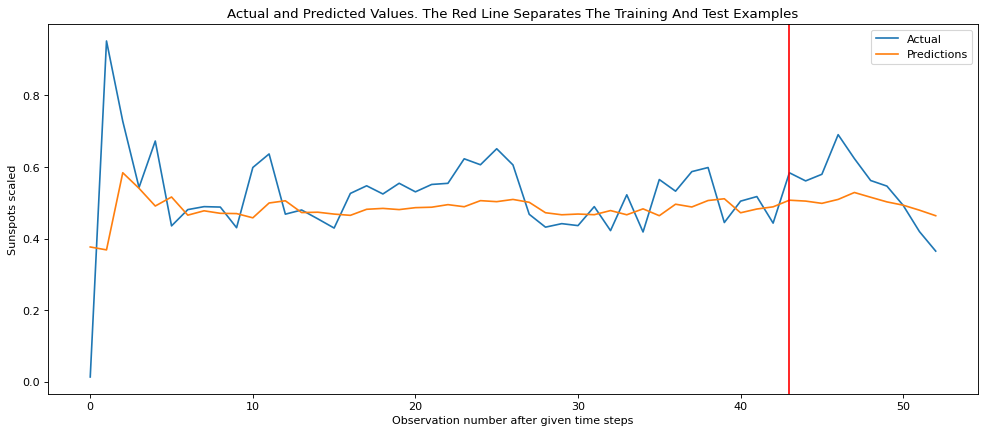

In [127]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)


# build and train a LSTM model with regularization

In [128]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(12, 1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))

# compile the lstm
lstm.compile(optimizer='adam', loss='mean_squared_error')

# train the lstm
lstm_history = lstm.fit(trainX, trainY, epochs=20, batch_size=1,verbose=2, validation_split=0.2)


Epoch 1/20
34/34 - 6s - loss: 0.0739 - val_loss: 0.0149 - 6s/epoch - 169ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0345 - val_loss: 0.0147 - 276ms/epoch - 8ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0282 - val_loss: 0.0104 - 252ms/epoch - 7ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0257 - val_loss: 0.0053 - 388ms/epoch - 11ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0291 - val_loss: 0.0078 - 303ms/epoch - 9ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0235 - val_loss: 0.0063 - 410ms/epoch - 12ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0202 - val_loss: 0.0122 - 257ms/epoch - 8ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0217 - val_loss: 0.0054 - 253ms/epoch - 7ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0241 - val_loss: 0.0064 - 261ms/epoch - 8ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0214 - val_loss: 0.0060 - 250ms/epoch - 7ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0250 - val_loss: 0.0123 - 223ms/epoch - 7ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0199 - val_loss: 0.0046 - 229ms/epoch - 7ms/step
Epoch 13/20
34/34 - 0s -

# plot the train and validation loss curve

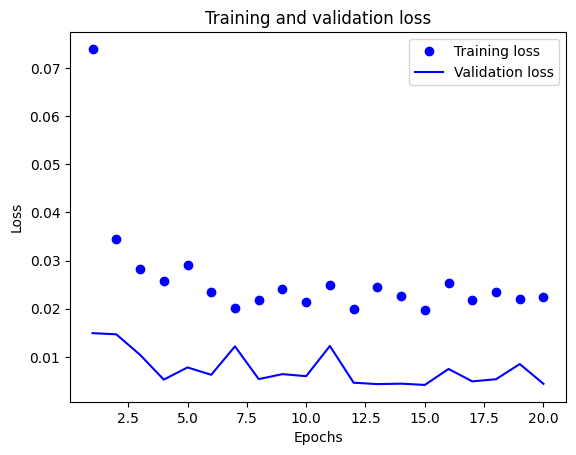

In [129]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get RMSE value for train and test data

In [130]:
# make predictions
train_predict = lstm.predict(trainX)
test_predict = lstm.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 29ms/step
Train RMSE: 0.123 RMSE
Test RMSE: 0.075 RMSE


# plot the result

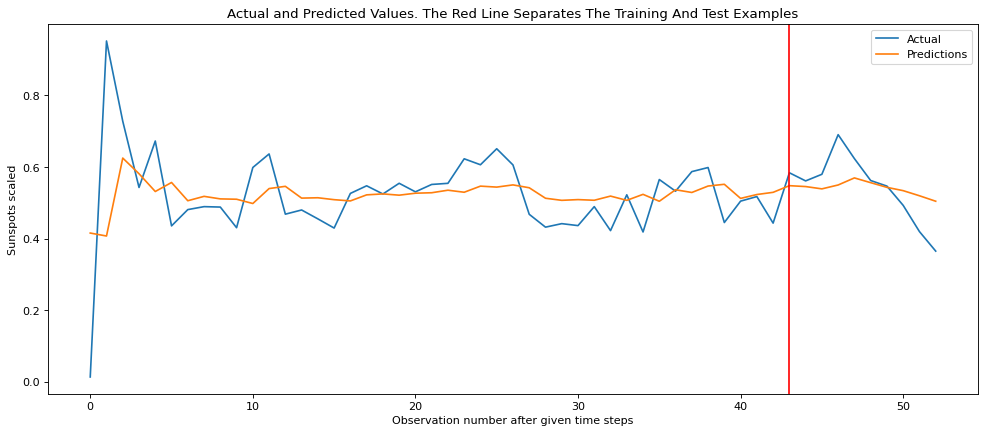

In [131]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)


# build and train a GRU model

In [135]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(12,1), activation='tanh'))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(12,1), activation='tanh'))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(12,1), activation='tanh'))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
# The output layer
regressorGRU.add(Dense(units=1))

# compiling the model

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

gru_history = regressorGRU.fit(trainX, trainY, epochs=20, batch_size=1,verbose=2, validation_split=0.2)

Epoch 1/20
34/34 - 8s - loss: 0.0553 - val_loss: 0.0514 - 8s/epoch - 224ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0282 - val_loss: 0.0039 - 431ms/epoch - 13ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0201 - val_loss: 0.0116 - 414ms/epoch - 12ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0231 - val_loss: 0.0055 - 403ms/epoch - 12ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0230 - val_loss: 0.0040 - 458ms/epoch - 13ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0240 - val_loss: 0.0171 - 432ms/epoch - 13ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0255 - val_loss: 0.0050 - 434ms/epoch - 13ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0196 - val_loss: 0.0047 - 479ms/epoch - 14ms/step
Epoch 9/20
34/34 - 0s - loss: 0.0223 - val_loss: 0.0194 - 384ms/epoch - 11ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0245 - val_loss: 0.0040 - 397ms/epoch - 12ms/step
Epoch 11/20
34/34 - 1s - loss: 0.0234 - val_loss: 0.0100 - 605ms/epoch - 18ms/step
Epoch 12/20
34/34 - 0s - loss: 0.0171 - val_loss: 0.0173 - 428ms/epoch - 13ms/step
Epoch 13/20
34/

# plot the train and validation loss curve

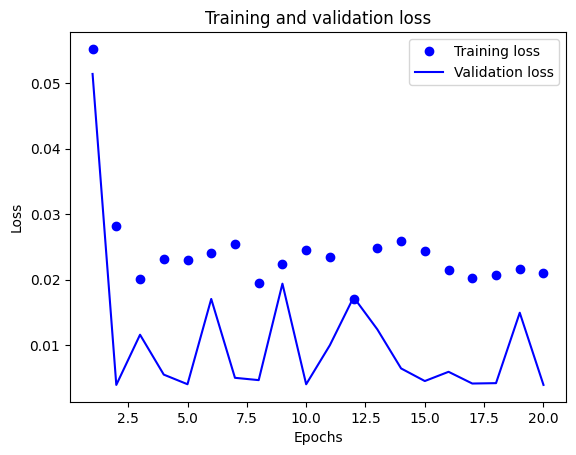

In [136]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get RMSE value for train and test data

In [137]:
# make predictions
train_predict = regressorGRU.predict(trainX)
test_predict = regressorGRU.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 32ms/step
Train RMSE: 0.124 RMSE
Test RMSE: 0.086 RMSE


# plot the result

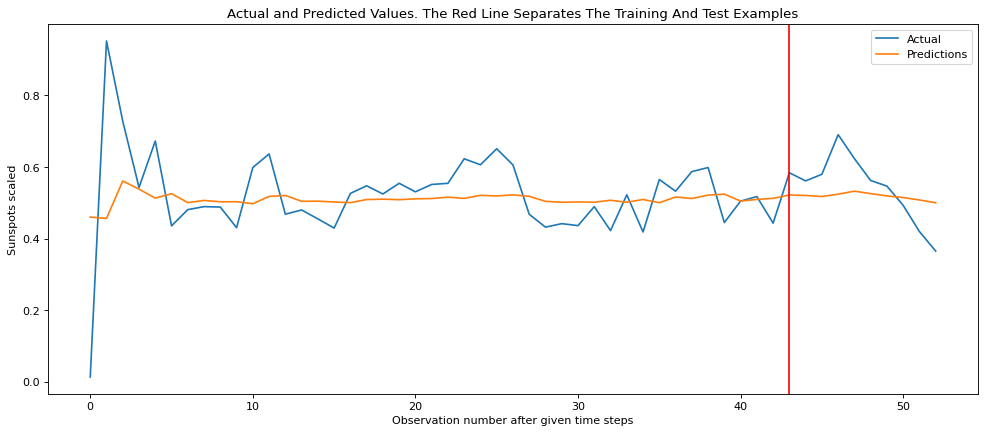

In [138]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)


# build and train a GRU model with regularization

In [139]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(12,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(12,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(12,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# compiling the model

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

gru_history = regressorGRU.fit(trainX, trainY, epochs=20, batch_size=1,verbose=2, validation_split=0.2)

Epoch 1/20


/Users/hengxinwu/580/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


34/34 - 7s - loss: 0.0702 - val_loss: 0.0151 - 7s/epoch - 215ms/step
Epoch 2/20
34/34 - 0s - loss: 0.0316 - val_loss: 0.0280 - 450ms/epoch - 13ms/step
Epoch 3/20
34/34 - 0s - loss: 0.0381 - val_loss: 0.0051 - 438ms/epoch - 13ms/step
Epoch 4/20
34/34 - 0s - loss: 0.0302 - val_loss: 0.0117 - 447ms/epoch - 13ms/step
Epoch 5/20
34/34 - 0s - loss: 0.0269 - val_loss: 0.0063 - 425ms/epoch - 12ms/step
Epoch 6/20
34/34 - 0s - loss: 0.0293 - val_loss: 0.0105 - 464ms/epoch - 14ms/step
Epoch 7/20
34/34 - 0s - loss: 0.0265 - val_loss: 0.0046 - 474ms/epoch - 14ms/step
Epoch 8/20
34/34 - 0s - loss: 0.0314 - val_loss: 0.0053 - 442ms/epoch - 13ms/step
Epoch 9/20
34/34 - 1s - loss: 0.0260 - val_loss: 0.0054 - 591ms/epoch - 17ms/step
Epoch 10/20
34/34 - 0s - loss: 0.0225 - val_loss: 0.0074 - 467ms/epoch - 14ms/step
Epoch 11/20
34/34 - 0s - loss: 0.0260 - val_loss: 0.0039 - 412ms/epoch - 12ms/step
Epoch 12/20
34/34 - 1s - loss: 0.0256 - val_loss: 0.0140 - 886ms/epoch - 26ms/step
Epoch 13/20
34/34 - 1s - l

# plot the train and validation loss curve

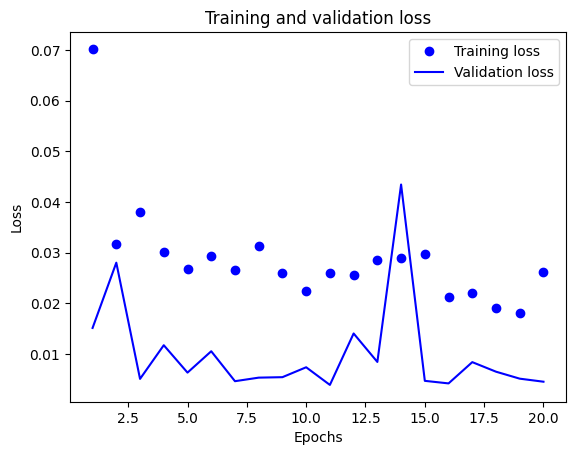

In [141]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [142]:
# make predictions
train_predict = regressorGRU.predict(trainX)
test_predict = regressorGRU.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 31ms/step
Train RMSE: 0.125 RMSE
Test RMSE: 0.086 RMSE


# plot the result

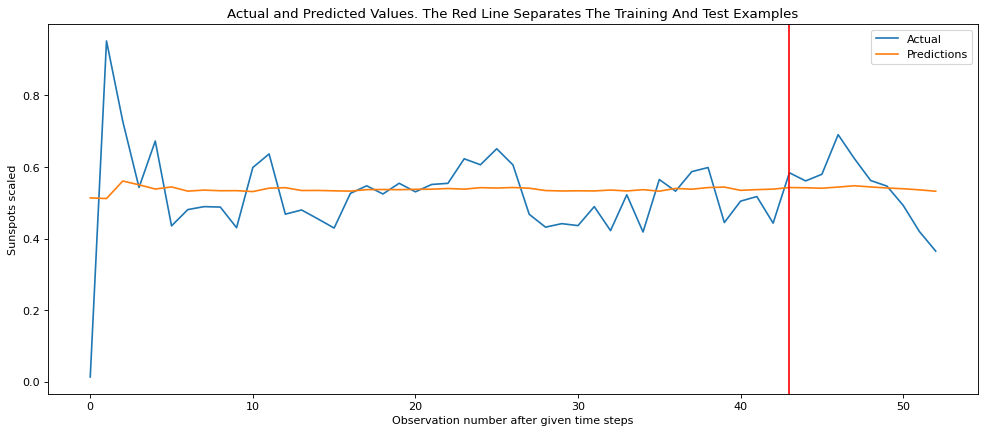

In [143]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)
